In [10]:
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [11]:
# import dataset 
data = np.loadtxt(open('mnist_train_small.csv', 'rb'), delimiter=',')
# extract labels (number ID's) and remove from data
labels = data[:,0]
data = data[:,1:]

dataNorm = data / np.max(data)

In [12]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data,test_data,train_labels, test_labels= train_test_split(dataT, labelsT,test_size=0.1)
 
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
 
batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
def createTheMNISTNet():
    
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(784,64)
            
            ### hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output =  nn.Linear(32,10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x),dim=1)
            
    net = Net()
    
    lossFn = nn.NLLLoss()
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    return net,lossFn,optimizer

Summary of model:
Net(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
 
Input layer weights:
torch.Size([64, 784])
Parameter containing:
tensor([[-0.0082,  0.0097,  0.0329,  ...,  0.0042, -0.0279,  0.0009],
        [ 0.0109,  0.0031,  0.0212,  ...,  0.0007,  0.0286, -0.0215],
        [-0.0290,  0.0256, -0.0190,  ..., -0.0069, -0.0211,  0.0264],
        ...,
        [ 0.0079, -0.0271, -0.0150,  ...,  0.0136,  0.0163, -0.0094],
        [-0.0356,  0.0340,  0.0062,  ...,  0.0164,  0.0095,  0.0132],
        [-0.0052,  0.0242, -0.0076,  ..., -0.0267, -0.0197, -0.0219]],
       requires_grad=True)
 


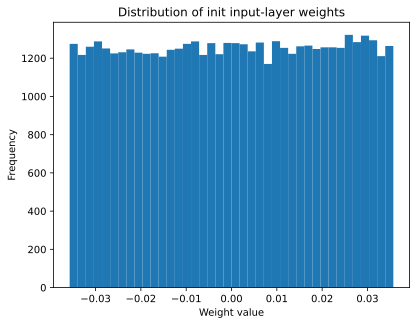

In [14]:
### exploring the "innards" of the model

# create a tmep model to explore
net = createTheMNISTNet()[0]

# summary of the entire model
print("Summary of model:")
print(net)
print(' ')

# # explore one of the layers
# print("Summary of input layers:")
# print(vars(net.input))
# print(' ')

# check out the matrix of weights
print("Input layer weights:")
print(net.input.weight.shape)
print(net.input.weight)
print(' ')


w = net.input.weight.detach().flatten()
plt.hist(w,40)
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.title("Distribution of init input-layer weights")
plt.show()

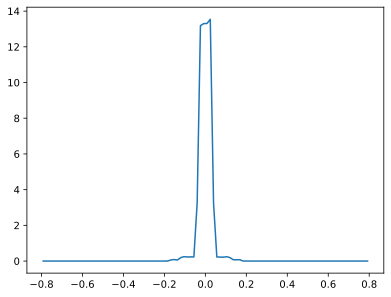

In [15]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])
  
  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy




# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

In [16]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses and accuracies
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize histogram variables
  histx = np.zeros((numepochs,100))
  histy = np.zeros((numepochs,100))


  # loop over epochs
  for epochi in range(numepochs):

    # get the weights distribution at the start of this epoch
    histx,histy[epochi,:] = weightsHistogram(net)
  
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches        = torch.argmax(yHat,axis=1) == y # booleans (false/true)
      matchesNumeric = matches.float()                # convert to numbers (0/1)
      accuracyPct    = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )                  # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy


In [17]:
trainAcc,testAcc,losses,net,histx,histy = function2trainTheModel()


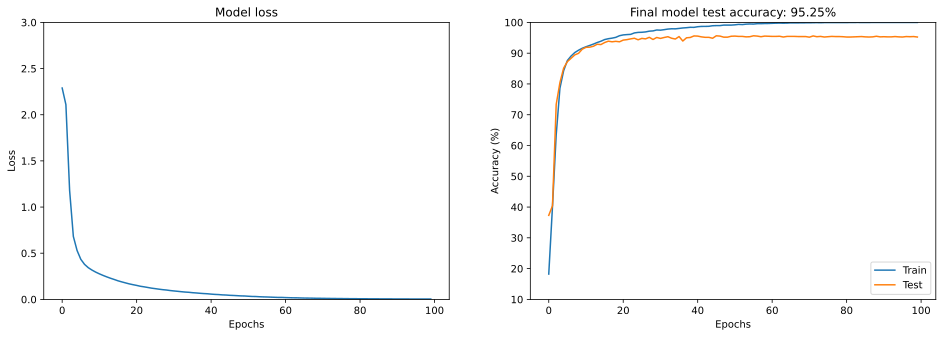

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

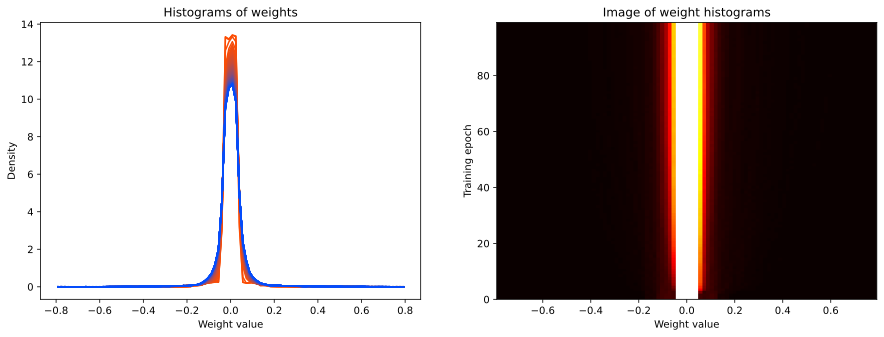

In [19]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()